## Gradients

PyWake supports three methods for computing gradients:


| Method               | Pro                                  | Con |
| :------               | :---                                  | :--- |
| Finite difference (`fd`)   | - Works out of the box in most cases<br>- Fast for small problems | - Less accurate <br>- Sensitive to stepsize<br>- Requires `n+1` function evaluation |
| Complex step (`cs`)        | - More accurate<br>- Works out of the box or with a few minor changes<br> - Fast for small problems | - Requires `n` function evaluations
| Automatic differentiation (`autograd`)           | - Exact result<br>- Requires 1 smart function evaluation | - `numpy` must be replaced with `autograd.numpy`<br>- Often code changes and debugging is required<br>- Debugging is very hard<br>- Gradient functions (e.g. using `fd` or `cs`) must be specified if `autograd` fails

### Example problem

To demonstrate the three methods we first define an example function, `f(x)`, with one input vector of three elements, `x = [1,2,3]`

$ f(x)=\sum_x{2x^3\sin(x)}$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
def f(x):
    return np.sum((2 * x**3) * np.sin(x))

def df(x):
    # analytical gradient used for comparison
    return 6*x**2 * np.sin(x)  + 2*x**3 * np.cos(x)

x = np.array([1,2,3], dtype=float)

Plot variation+gradients of `f` with respect to $x_0, x_1, x_2$

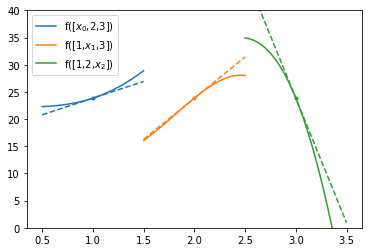

In [2]:
dx_lst = np.linspace(-.5,.5,100)
import matplotlib.pyplot as plt
for i in range(3):
    label="f([1,2,3])".replace(str(i+1),f"$x_{i}$")
    c = plt.plot(x[i] + dx_lst, [f(x + np.roll([dx,0,0],i)) for dx in dx_lst], label=label)[0].get_color()
    plt.plot(x[i]+[-.5,.5], f(x) + df(x)[i]*np.array([-.5,.5]), '--', color=c)
    plt.plot(x[i], f(x), '.', color=c)
plt.ylim([0,40])
plt.legend()


### Finite difference `fd`

$\frac{d f(x)}{dx} = \frac{f(x+h) - f(x)}{h}$

Finite difference applied to the example function:


In [3]:
print ("Analytical gradient:", list(df(x)))
h = 1e-6
for i in range(3):
    print (f"Finite difference gradient wrt. x{i}:", (f(x+np.roll([h,0,0],i)) - f(x))/h)

Analytical gradient: [6.129430520583658, 15.164788859062082, -45.83911438119122]
Finite difference gradient wrt. x0: 6.129437970514573
Finite difference gradient wrt. x1: 15.164782510623809
Finite difference gradient wrt. x2: -45.839169114714196


In  this example the gradients are accurate to 4th or 5th decimal. The accuracy, however, is highly dependent on the step size, `h`. If the step size is too small the result becomes inaccurate due to nummerical issues. If the step size, on the other hands, becomes to big, then the result represents the gradient of a neighboring point. 
This compromize is illusated below:

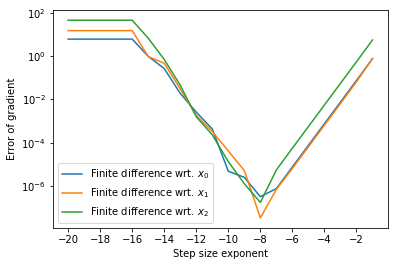

In [4]:
h_lst = 10.**(-np.arange(1,21)) # step sizes [1e-1, ..., 1e-20]

for i in range(3):
    # Plot error compared to analytical gradient, df(x)
    plt.semilogy(np.log10(h_lst), [np.abs(df(x)[i] - (f(x+np.roll([h,0,0],i))-f(x))/h) for h in h_lst], 
                 label=f'Finite difference wrt. $x_{i}$')

plt.ylabel('Error of gradient')
plt.xlabel('Step size exponent')
plt.xticks(np.arange(-20,-1,2))
plt.legend()

### Complex step

The complex step is described [here](https://blogs.mathworks.com/cleve/2013/10/14/complex-step-differentiation/).

It utilizes that 

$\frac {d f(x)}{x}= \frac{\operatorname{Im}(f(x+ih))}{h}+O(h^2)$

Applied to the example function, the result is accurate to the 15th decimal.

In [5]:
print ("Analytical gradient:", list(df(x)))
h = 1e-10

for i in range(3):
    print (f"Finite difference gradient wrt. x{i}:", np.imag(f(x+np.roll([h*1j,0,0],i)))/h)

Analytical gradient: [6.129430520583658, 15.164788859062082, -45.83911438119122]
Finite difference gradient wrt. x0: 6.129430520583658
Finite difference gradient wrt. x1: 15.164788859062082
Finite difference gradient wrt. x2: -45.83911438119122


Furthermore, the result is much less sensitive to the step size as seen below

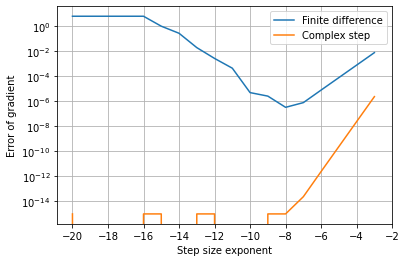

In [6]:
h_lst = 10.**(-np.arange(3,21))

plt.semilogy(np.log10(h_lst), [np.abs(df(x)[0] - (f(x+[h,0,0])-f(x))/h) for h in h_lst], label='Finite difference')
plt.semilogy(np.log10(h_lst), [np.abs(df(x)[0] - np.imag(f(x+[h*1j,0,0]))/h) for h in h_lst], label='Complex step')
plt.ylabel('Error of gradient')
plt.xlabel('Step size exponent')
plt.grid()
plt.xticks(np.arange(-20,-1,2))
plt.legend()

#### Common code changes

The complex step method calls the function with a complex number, i.e. all intermediate functions and routines must support  complex number. A few `numpy` functions has different or undefined behaviour for complex numbers, so often a few changes is required. In PyWake the module, `py_wake.utils.gradients`, contains a set of replacement functions that supports complext number, e.g.:

- `abs`
  - For a real value, `x`, `abs(x)` returns the positive value, while for a complex number, it returns the distance from 0 to z, $abs(a+bi)= \sqrt{a^2+b^2}$. 
  - In most cases `abs` should therefore be replaced by `gradients.cabs`, which returns `np.where(x<0,-x,x)`)
- `np.hypot(a,b)`
  - `np.hypot` does not support complex numbers
  - replace with `gradients.hypot`, which returns `np.sqrt(a\*\*2+b\*\*2)` if `a` or `b` is complex
- `np.interp(xp,x,y)`
  - replace with `gradients.interp(xp,x,y)`
- `np.logaddexp(x,y)`
  - replace with  `gradients.logaddexp(x,y)` 
  
Furthermore, the imaginary part must be preserved when creating new arrays, i.e.
- `np.array(x,dtype=float)` -> `np.array(x,dtype=(float, np.complex128)[np.iscomplexobj(x)])`


### Autograd

[Autograd](https://github.com/HIPS/autograd) is a python package that can automatically differentiate native Python and Numpy code.

Autograd performs a two step automatic differentiation process.

First the normal result is calculated and during this process autograd setups up a calculation tree where each element in the tree holds the associated gradient functions:

<img src="../_static/autograd_calculation.svg" width="400"/>


For most numpy functions, the associated gradient function is predefined when using `autograd.numpy` instead of `numpy`. You can see the autograd module that defines the gradients of numpy functions [here](https://github.com/HIPS/autograd/blob/master/autograd/numpy/numpy_vjps.py#L32) and the functions used in the example is shown here:

```python
defvjp(anp.multiply,    lambda ans, x, y : unbroadcast_f(x, lambda g: y * g),
                        lambda ans, x, y : unbroadcast_f(y, lambda g: x * g))
defvjp(anp.add,         lambda ans, x, y : unbroadcast_f(x, lambda g: g),
                        lambda ans, x, y : unbroadcast_f(y, lambda g: g))
defvjp(anp.power,
    lambda ans, x, y : unbroadcast_f(x, lambda g: g * y * x ** anp.where(y, y - 1, 1.)),
    lambda ans, x, y : unbroadcast_f(y, lambda g: g * anp.log(replace_zero(x, 1.)) * x ** y))
defvjp(anp.sin,    lambda ans, x : lambda g: g * anp.cos(x))
```

In the second step, the gradients are calculated by backward propagation
<img src="../_static/autograd_differentiation.svg" width="400"/>

Applied to the example function, `autograd`, gives the exact results.

In [7]:
from autograd import elementwise_grad
from autograd import numpy as anp
def f_anp(x):
    return anp.sum((2 * x**3) * anp.sin(x))

print ("Analytical gradient:", list(df(x)))
print (f"Autograd gradient:", list(elementwise_grad(f_anp)(x)))

Analytical gradient: [6.129430520583658, 15.164788859062082, -45.83911438119122]
Autograd gradient: [6.129430520583658, 15.164788859062082, -45.83911438119122]


Note, a new function, `f_anp` implemented with `autograd.numpy` instead of `numpy` is needed for autograd to work out of the box.

In PyWake, however, a wrapper, `py_wake.utils.gradients.autograd` has been implemented that handles the numpy replacemenet automatically:

In [8]:
from py_wake.utils.gradients import autograd
autograd(f)(x)

array([  6.12943052,  15.16478886, -45.83911438])

#### Scalability
As seen in the examples, autograd computed the gradients with respect to all input elements in one smart (but slow) function evaluation, while finite difference and complex step required `n + 1` and `n` function evaluations, respectively.

This difference has a high impact on the performance of large scale problems. The plot below shows the time required to compute the gradients as a function of the number of elements in the input vector. In this example the `fd`, `cs` and `autograd` functions from `py_wake.utils.gradients` is utilized.

Text(0, 0.5, 'Time [s]')

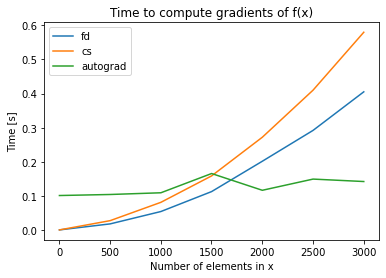

In [9]:
from py_wake.utils.gradients import fd, cs, autograd
from py_wake.tests.check_speed import timeit

n_lst = np.arange(1,3500,500)
x_lst = [np.random.random(n) for n in n_lst]
def get_gradients(method,x):
    return method(f, vector_interdependence=True)(x)

for method in  [fd, cs, autograd]:
    plt.plot(n_lst, [np.mean(timeit(get_gradients, min_time=.2)(method,x)[1]) for x in x_lst], label=method.__name__)
plt.legend()
plt.title('Time to compute gradients of f(x)')
plt.xlabel('Number of elements in x')
plt.ylabel('Time [s]')

#### Common code changes

- `x[m] = 0` -> `x = np.where(m,0,x)`
  - Item assignment not supported
  

### Gradients in PyWake

As described above, PyWake, contains a module, `py_wake.utils.gradients` which defines the three methods, `fd`, `cs` and `autograd`, as well as a number of helper functions and constructs.

At the moment, the three gradient methods are supported by the following models:

- WindFarmModels
  - [x] PropagateDownwind
  - [x] All2AllIterative
- WakeDeficitModels
  - [x] NOJDeficit
  - [x] FugaDeficit
  - [x] FugaYawDeficit
  - [x] BastankhahGaussianDeficit
  - [ ] CarbajofuertesGaussianDeficit
  - [x] IEA37SimpleBastankhahGaussianDeficit
  - [x] NiayifarGaussianDeficit
  - [x] TurboGaussianDeficit
  - [ ] ZongGaussianDeficit
  - [x] GCLDeficit
  - [x] NoWakeDeficit
  - [x] NOJLocalDeficit
  - [x] TurboNOJDeficit
- BlockageDeficitModels
  - [x] FugaDeficit
  - [x] FugaYawDeficit
  - [x] HybridInduction
  - [x] SelfSimilarityDeficit2020
  - [x] VortexDipole
  - [x] RankineHalfBody
  - [x] Rathmann
  - [x] RathmannScaled
  - [x] SelfSimilarityDeficit
  - [ ] VortexCylinder
- SuperpositionModels
  - [x] LinearSum
  - [x] MaxSum
  - [x] SquaredSum
  - [ ] WeightedSum
- RotorCenterModels
  - [x] RotorCenter
  - [x] CGIRotorAvg
  - [x] EqGridRotorAvg
  - [x] GQGridRotorAvg
  - [x] GridRotorAvg
  - [x] PolarGridRotorAvg
- DeflectionModels
  - [ ] FugaDeflection
  - [ ] GCLHillDeflection
  - [ ] JimenezWakeDeflection
- TurbulenceModels
  - [x] CrespoHernandez
  - [ ] GCLTurbulence
  - [x] STF2005TurbulenceModel
  - [x] STF2017TurbulenceModel
- AddedTurbulenceSuperpositionModel
  - [x] LinearSum
  - [x] MaxSum
  - [x] SqrMaxSum
  - [x] SquaredSum
- GroundModels
  - [x] NoGround
  - [x] Mirror
  - [x] MirrorSquaredSum
- Sites
  - [x] IEA37Site
  - [x] Hornsrev1Site
  - [ ] ParqueFicticioSite
- ShearModels
  - [ ] PowerShear
  - [ ] LogShear
- WindTurbines
  - [x] IEA37_WindTurbines
  - [x] V80

### Optimization with Topfarm2

In the following sections the examples are optimized using [Topfarm2](https://topfarm.pages.windenergy.dtu.dk/TopFarm2/), an open source Python package developed by DTU Wind Energy to help with wind-farm optimizations. It has a lot of nice built-in features and wrappers

In [1]:
# install topfarm if not present
try:
    import topfarm
except ImportError:
    !pip install topfarm --user

### Example, optimize AEP wrt. wind turbine position, x,y

In this example we optimize the AEP of the IEAWind Task 37 Case Study 1.

As TopFarm2 already contains a cost model component, `PyWakeAEPCostModelComponent`, for this kind of problem, setting up the problem is really simple.

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from py_wake.deficit_models.gaussian import IEA37SimpleBastankhahGaussian
from py_wake.examples.data.iea37._iea37 import IEA37Site, IEA37WindTurbines
from py_wake.utils.gradients import autograd, fd, cs
from topfarm._topfarm import TopFarmProblem
from topfarm.cost_models.py_wake_wrapper import PyWakeAEPCostModelComponent
from topfarm.constraint_components.boundary import CircleBoundaryConstraint
from topfarm.constraint_components.spacing import SpacingConstraint
from topfarm.easy_drivers import EasyScipyOptimizeDriver

def get_topfarmProblem_xy(n_wt, grad_method, maxiter):
    site = IEA37Site(n_wt)
    wt = IEA37WindTurbines()
    wfm = IEA37SimpleBastankhahGaussian(site, wt)
    x, y = site.initial_position.T
    return TopFarmProblem(design_vars={'x': x, 'y': y},
                          cost_comp=PyWakeAEPCostModelComponent(windFarmModel=wfm, n_wt=len(x), grad_method=grad_method,
                                                                wd=np.arange(0, 360, 22.5), ws=[9.8]),
                          driver=EasyScipyOptimizeDriver(maxiter=maxiter),
                          constraints=[CircleBoundaryConstraint(center=[0, 0], radius=np.round(np.hypot(x, y).max())),
                                       SpacingConstraint(min_spacing=2 * wt.diameter())])

In [12]:
def optimize_and_plot(n_wt, maxiter, methods=[autograd, fd,cs]):
    plt.title(f'{n_wt} Wind turbines')
    for method in methods:
        tf = get_topfarmProblem_xy(n_wt,method,maxiter)
        cost, state, recorder = tf.optimize()
        t,aep = [recorder[v] for v in ['timestamp','AEP']]
        plt.plot(t-t[0],aep, label=getattr(method,'__name__', "None"))
    plt.legend()
    plt.ylabel('AEP [GWh]')
    plt.xlabel('Time [s]')    

Optimize the site with 16 wind turbines. Below the number of iterations is limited to 3

Iteration limit reached    (Exit mode 9)
            Current function value: [-366.99774258]
            Iterations: 3
            Function evaluations: 3
            Gradient evaluations: 3
Optimization FAILED.
Iteration limit reached
-----------------------------------
Iteration limit reached    (Exit mode 9)
            Current function value: [-366.9977426]
            Iterations: 3
            Function evaluations: 3
            Gradient evaluations: 3
Optimization FAILED.
Iteration limit reached
-----------------------------------
Iteration limit reached    (Exit mode 9)
            Current function value: [-366.99774258]
            Iterations: 3
            Function evaluations: 3
            Gradient evaluations: 3
Optimization FAILED.
Iteration limit reached
-----------------------------------


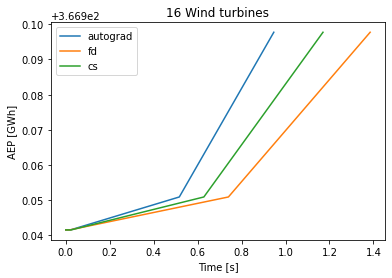

In [13]:
optimize_and_plot(n_wt=16, maxiter=3)

Optimize the site with 64 wind turbines. Below the number of iterations is limited to 3

Iteration limit reached    (Exit mode 9)
            Current function value: [-1295.38983372]
            Iterations: 3
            Function evaluations: 3
            Gradient evaluations: 3
Optimization FAILED.
Iteration limit reached
-----------------------------------
Iteration limit reached    (Exit mode 9)
            Current function value: [-1295.38983362]
            Iterations: 3
            Function evaluations: 3
            Gradient evaluations: 3
Optimization FAILED.
Iteration limit reached
-----------------------------------
Iteration limit reached    (Exit mode 9)
            Current function value: [-1295.38983372]
            Iterations: 3
            Function evaluations: 3
            Gradient evaluations: 3
Optimization FAILED.
Iteration limit reached
-----------------------------------


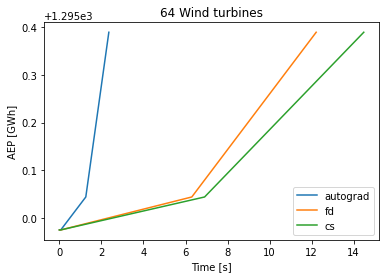

In [14]:
optimize_and_plot(n_wt=64, maxiter=3)

### Optimize x wrt. y

To optimize x wrt. y, you simply need to setup a function, `x = f(y)`.

In the examle below, we will use a wind turbine that can be de-rated

#### De-ratable wind turbine

The relation between power and ct of the de-ratable wind turbine is obtained from 1D momentum theory

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from py_wake.wind_turbines._wind_turbines import WindTurbine
from py_wake.wind_turbines.power_ct_functions import PowerCtFunction
from py_wake.utils.model_utils import fix_shape

def power_ct(ws, derating, run_only):
    derating = fix_shape(derating, ws)
    cp = 16 / 27 * (1 - derating)
    power = np.maximum(0, 1 / 2 * 1.225 * 50**2 * np.pi * cp * ws ** 3)

    # solve cp = 4 * a * (1 - a)**2 for a
    y = 27.0 / 16.0 * cp
    a = 2.0 / 3.0 * (1 - np.cos(np.arctan2(2 * np.sqrt(y * (1.0 - y)), 1 - 2 * y) / 3.0))
    ct = 4 * a * (1 - a)
    return [power, ct][run_only]


powerCtFunction = PowerCtFunction(input_keys=['ws', 'derating'], power_ct_func=power_ct, power_unit='w')
wt = WindTurbine(name="MyWT", diameter=100, hub_height=100, powerCtFunction=powerCtFunction)

The power and Ct curves as a function wind speed is plotted below for 0, 5 and 10% derating

(0.0, 1.0)

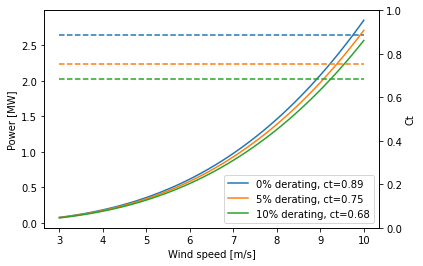

In [16]:
ax1 = plt.gca()
ax2 = plt.twinx(ax1)
ws = np.linspace(3, 10)
for derating in [0, .05, .1]:
    ct = wt.ct(ws, derating=derating)
    ax1.plot(ws, wt.power(ws, derating=derating) / 1e6, label='%d%% derating, ct=%.2f' % (derating * 100, ct[0]))
    ax2.plot(ws, ct,'--')

ax1.legend(loc='lower right')
ax1.set_xlabel('Wind speed [m/s]')
ax1.set_ylabel('Power [MW]')
ax2.set_ylabel('Ct')
ax2.set_ylim([0, 1])

#### Example, maximize mean power by optizing de-rating and hub height

In this example we will maximize the mean power by optimizing the individual wind turbine hub height and derating factors.

First we setup the `WindFarmModel` and the function to maximize, `mean_power`, which takes the hub height and derating factors as input:

In [17]:
from py_wake.deficit_models.gaussian import IEA37SimpleBastankhahGaussian
from py_wake.site import UniformSite
from py_wake.utils.gradients import autograd
from topfarm._topfarm import TopFarmProblem
from topfarm.cost_models.cost_model_wrappers import CostModelComponent
from topfarm.easy_drivers import EasyScipyOptimizeDriver

n_wt = 5
wfm = IEA37SimpleBastankhahGaussian(site=UniformSite(p_wd=[1],ti=.1), windTurbines=wt)
wt_x = np.arange(n_wt) * 4 * wt.diameter()
wt_y = np.zeros_like(wt_x)

def mean_power(zhub, derating):
    # WS_eff_ilk, TI_eff_ilk, power_ilk, ct_ilk, localWind, wt_inputs = wfm.calc_wt_interaction(...)
    # index 2 = power_ilk
    power_ilk = wfm.calc_wt_interaction(x_i=wt_x, y_i=wt_y, h_i=zhub, wd=[270], ws=[10], derating=derating)[2] 
    return np.mean(power_ilk)

Note, the normal `WindFarmModel.__call__` method, which is invoked by `wfm(x,y,...)` calls `WindFarmModel.calc_wt_interaction` and packs the result into a xarray dataset. This step breaks the autograd data flow. We therefore need to call [`WindFarmModel.calc_wt_interaction`](https://topfarm.pages.windenergy.dtu.dk/PyWake/api/WindFarmModel.html#py_wake.wind_farm_models.wind_farm_model.WindFarmModel.calc_wt_interaction) directly.

We use `autograd` to setup the gradient function. The input argument `argnum=[0,1]` makes it return the gradients of the `mean_power` function wrt. to both inputs, `zhub` and `derating`

In [18]:
dmean_power_dzhub_derating = autograd(mean_power, argnum=[0, 1])

In [19]:
dmean_power_dzhub_derating([100]*n_wt, [0]*n_wt)

[array([0., 0., 0., 0., 0.]),
 array([ 3.71659114e+20,  2.88392374e+20,  2.41722932e+20,  1.77225891e+20,
        -1.60329988e+05])]

Next step is to setup the `CostModelComponent`

In [20]:
cost_comp=CostModelComponent(input_keys=['zhub', 'derating'],
                              n_wt=n_wt,
                              cost_function=mean_power,
                              cost_gradient_function=dmean_power_dzhub_derating,
                              maximize=True # because we want to maximize the mean power
                             )

and the `TopFarmProblem`

In [21]:
tf = TopFarmProblem(design_vars={
                        # (initial_values, lower limit, upper limit)
                        'zhub': ([100]*n_wt, 80, 130),
                        'derating': ([0] * n_wt, 0, .9)},  
                    cost_comp=cost_comp,
                    expected_cost=1000, # expected cost impacts the size of the moves performed by the optimizer
                    )

As seen above the gradient of the mean power wrt. hub height is zero when all wind turbines have the same height. This means that the optimizer "thinks" that the solution cannot be improved. We therefore need to initialize the optimization with slightly different hub heights.

Furthermore, the derating must be above zero to avoid inequality constraint failure.

In [22]:
cost, state, recorder = tf.optimize(state={'zhub':np.arange(n_wt)+100, # 100,101,102,...
                                           'derating':[0.1]*n_wt # 10% initial derating
                                          })
print ()
print ('Optimized mean power', cost)
print ('Optimized state', state)

Optimization terminated successfully    (Exit mode 0)
            Current function value: [-1716.18730438]
            Iterations: 38
            Function evaluations: 56
            Gradient evaluations: 36
Optimization Complete
-----------------------------------

Optimized mean power -1716187.3043790367
Optimized state {'zhub': array([ 80., 130.,  80.,  80., 130.]), 'derating': array([0.08691683, 0.06260834, 0.19990203, 0.04530914, 0.        ])}


plot result

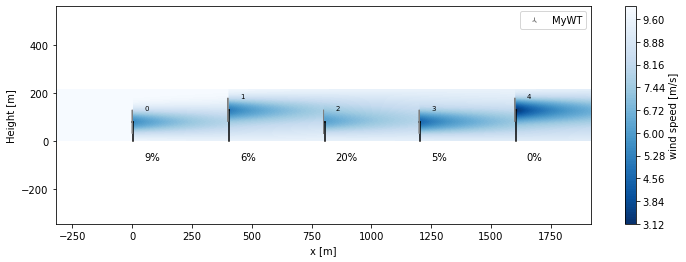

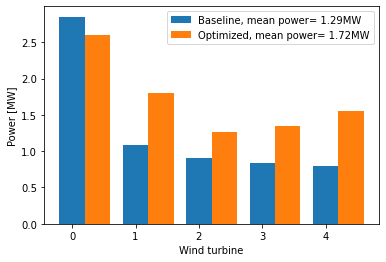

In [23]:
from py_wake import XZGrid
derating = state['derating']
h = state['zhub']

sim_res_ref = wfm(wt_x, wt_y, wd=[270], ws=[10], derating=[0] * n_wt)
sim_res_opt = wfm(wt_x, wt_y, h=h, wd=[270], ws=[10], derating=derating)
plt.figure(figsize=(12,4))
sim_res_opt.flow_map(XZGrid(y=0)).plot_wake_map()
for x_, d in zip(wt_x, derating):
    plt.text(x_ + 50, -80, "%d%%" % np.round(d * 100), fontsize=10)
plt.ylabel('Height [m]')
plt.xlabel('x [m]')

plt.figure()
for i, (sim_res, l) in enumerate([(sim_res_ref, 'Baseline'), (sim_res_opt, 'Optimized')]):
    plt.bar(np.arange(n_wt) + i * .4, sim_res.Power.squeeze() * 1e-6, width=.4,
            label='%s, mean power= %.2fMW' % (l, sim_res.Power.mean() * 1e-6))
plt.ylabel('Power [MW]')
plt.xlabel('Wind turbine')
plt.legend()
plt.show()